In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz
import itertools

In [3]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common

In [4]:
MEGAb_TO_b = 1e6
N_TCP = 'TCP'
N_UDP = 'UDP'
N_DOWN = 'Download'
N_UP = 'Upload'

N_STARLINK = 'Starlink'
N_STARLINK_REMOTE = 'Starlink Remote'
N_HOME = 'Home'

COL_TRANSF_DIR = 'Transfer Direction'
COL_PROT_TYPE = 'Protocol and Type'

TCP_DOWN = 'TCP Down'
UDP_DOWN = 'UDP Down'
TCP_UP = 'TCP Up'
UDP_UP = 'UDP Up'
PROTOCOLS_MAP = {TCP_DOWN: "*down.*.csv", UDP_DOWN: "*down*udp*.csv", 
                 TCP_UP: "*up.*[!p].csv", UDP_UP: "*receive*.udp.csv"}

PROTOCOLS_SEP_MAP = {TCP_DOWN: [N_TCP, N_DOWN], UDP_DOWN: [N_UDP, N_DOWN], 
                 TCP_UP: [N_TCP, N_UP], UDP_UP: [N_UDP, N_UP]}

PROT_TYPE_ORDER = [f'{N_TCP} {N_HOME}', f'{N_TCP} {N_STARLINK}', f'{N_UDP} {N_HOME}', f'{N_UDP} {N_STARLINK}']

TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'


N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_PROTOCOL = 'Protocol'

OUTPUT_FOLDER = 'output/throughput'

In [5]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_theme("paper", style='whitegrid', color_codes=True, rc=sns_params, palette='bright')
#sns.set_context("paper", )
#sns.set(rc=sns_params)

In [6]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [7]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    if keep == ['bandwidth'] or keep == 'all':
        convert_to_mb(combined_df)
    if keep != 'all':
        combined_df = combined_df[keep]
    return combined_df

In [8]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    for i, _ in enumerate(df.columns):
        df_map.iloc[:, i] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [9]:
def combine_reg(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df = remove_first_measures(combined_df, first)
        combined_df[N_REGIONS] = common.region_mapping[reg_name]

        if regions_df.empty:
            regions_df = combined_df
        else:
            regions_df = pd.concat([regions_df, combined_df])

    return regions_df


In [10]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Iperf_csv/*'):
    src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Iperf_csv/*'):
    src_dirs.append(('Home', folder))
#src_dirs = [('Starlink', 'data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp')]
src_dirs = [(N_STARLINK_REMOTE, 'data/Koeye/2022-05-20_koeye_starlink_csv_iperf3/')]
src_dirs += [(N_STARLINK_REMOTE, 'data/Koeye/2022-05-21_koeye_starlink_csv_iperf3/')]
src_dirs

[('Starlink Remote', 'data/Koeye/2022-05-20_koeye_starlink_csv_iperf3/'),
 ('Starlink Remote', 'data/Koeye/2022-05-21_koeye_starlink_csv_iperf3/')]

In [11]:
df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/2022-06-05_end_all_starlink_iperf3.csv', index_col=0)
df_regs_old['timestamp'] = pd.to_datetime(df_regs_old['timestamp'])
df_regs_old

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,Regions,Protocol,Transfer Direction,Type,Protocol and Type
0,2022-02-05 22:49:05.001078016,0.000000,NaN,NaN,NaN,NaN,Mumbai,TCP,Upload,Starlink,TCP Starlink
1,2022-02-09 23:23:34.000613888,0.000000,NaN,NaN,NaN,NaN,Bahrain,TCP,Upload,Starlink,TCP Starlink
2,2022-02-06 22:20:13.000148992,0.000000,NaN,NaN,NaN,NaN,Singapore,TCP,Upload,Starlink,TCP Starlink
3,2022-02-09 23:23:30.000144896,0.000000,NaN,NaN,NaN,NaN,Bahrain,TCP,Upload,Starlink,TCP Starlink
4,2022-01-31 22:04:48.000264960,0.000000,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home
361846,2022-05-29 14:10:28.000004096,838.120572,0.070071,617.0,72969.0,0.845565,N. California,UDP,Download,Home,UDP Home
361847,2022-05-28 10:01:02.000055040,838.443014,0.055429,793.0,73169.0,1.083792,Sydney,UDP,Download,Home,UDP Home
361848,2022-05-30 17:09:39.000015104,842.372040,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home


In [12]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    max_fail = len(PROTOCOLS_MAP)
    count = 0
    for (protocol, pattern) in PROTOCOLS_MAP.items():
        #df = concat_df(args.src_folder, UDP_UP, [JITTER])
        #df_temp = combine_reg(folder, pattern, first=1, keep='all')
        #try:
        df_temp = combine_reg(folder, pattern, first=3, keep='all')
        #except ValueError:
        #    print(f'Error getting {protocol}: {folder}')
        #    count += 1
        #    continue
        
        prot_dir = PROTOCOLS_SEP_MAP[protocol]
        df_temp[N_PROTOCOL] = prot_dir[0]
        df_temp[COL_TRANSF_DIR] = prot_dir[1]
        df_temp[N_TYPE] = type_name
        df_temp[COL_PROT_TYPE] = prot_dir[0] + ' ' + type_name
        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
    if count >= max_fail:
        raise ValueError('MAJOR error')
        
df

,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
timestamp,,,,,,,,,,
2022-05-21 16:10:21.000000000,-1.000000,Sao Paulo,TCP,Download,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
2022-05-21 16:10:22.000087040,-1.000000,Sao Paulo,TCP,Download,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
2022-05-21 16:10:23.000089088,-1.000000,Sao Paulo,TCP,Download,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
2022-05-21 16:10:24.000189184,-1.000000,Sao Paulo,TCP,Download,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
2022-05-21 16:10:25.000146176,32.632198,Sao Paulo,TCP,Download,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-23 10:18:55.000171776,16.034022,Mumbai,UDP,Upload,Starlink Remote,UDP Starlink Remote,4.697327,84.0,1468.0,5.722071
2022-05-23 10:18:56.000061952,15.290895,Mumbai,UDP,Upload,Starlink Remote,UDP Starlink Remote,3.295236,93.0,1413.0,6.581741
2022-05-23 10:18:57.000060928,14.768463,Mumbai,UDP,Upload,Starlink Remote,UDP Starlink Remote,3.676041,105.0,1380.0,7.608696


In [13]:
df_regs = df.replace(-1, pd.NA)
#df_regs = df_regs.where(df_regs.notnull(), None)
df_regs = df_regs.dropna(subset='bandwidth').astype({'bandwidth': float, 'jitter_ms': float,
                                 'lost_packets': float, 'packets': float, 'lost_percent': float})
df_regs = df_regs.sort_values('bandwidth')
df_regs.reset_index(inplace=True)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')

print(df_regs.dtypes)
df_regs#

timestamp             datetime64[ns]
bandwidth                    float64
Regions                       object
Protocol                      object
Transfer Direction            object
Type                          object
Protocol and Type             object
jitter_ms                    float64
lost_packets                 float64
packets                      float64
lost_percent                 float64
dtype: object


,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.342688,16088.0,25402.0,63.333596
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,1.899351,19160.0,28475.0,67.287094
23043,2022-05-23 15:29:23.000088064,108.229415,Sydney,UDP,Download,Starlink Remote,UDP Starlink Remote,0.494288,17758.0,27101.0,65.525257
23044,2022-05-23 15:29:24.000087040,108.634752,Sydney,UDP,Download,Starlink Remote,UDP Starlink Remote,0.493384,16460.0,25838.0,63.704621


In [14]:
df_regs_all  = df_regs
#df_regs_all[N_TYPE] = df_regs[N_TYPE].map({N_STARLINK: N_STARLINK_KOEYE})
df_regs_all = pd.concat([df_regs_all, df_regs_old])
df_regs_all

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN
361846,2022-05-29 14:10:28.000004096,838.120572,N. California,UDP,Download,Home,UDP Home,0.070071,617.0,72969.0,0.845565
361847,2022-05-28 10:01:02.000055040,838.443014,Sydney,UDP,Download,Home,UDP Home,0.055429,793.0,73169.0,1.083792
361848,2022-05-30 17:09:39.000015104,842.372040,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN


In [15]:
# Differentiate outliers
N_THROUGHPUT_OUTLIERS = 'Throughput Outliers'
df_outliers = df_regs_all.copy()
#zscore = np.abs(stats.zscore(df_outliers['bandwidth'], nan_policy='omit'))
zscore = np.abs(df_outliers.groupby([
    N_TYPE, COL_TRANSF_DIR, N_PROTOCOL, N_REGIONS])['bandwidth'].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_THROUGHPUT_OUTLIERS] = zscore >= 3
df_outliers = df_outliers.sort_values('bandwidth')
df_outliers

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent,Throughput Outliers
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000,False
5622,2022-02-04 23:21:51.000119808,0.000000,Bahrain,TCP,Upload,Starlink,TCP Starlink,NaN,NaN,NaN,NaN,False
5621,2022-01-31 22:20:37.001062144,0.000000,Singapore,TCP,Upload,Starlink,TCP Starlink,NaN,NaN,NaN,NaN,False
5620,2022-01-31 22:20:40.001078016,0.000000,Singapore,TCP,Upload,Starlink,TCP Starlink,NaN,NaN,NaN,NaN,False
5619,2022-01-31 22:20:39.000755968,0.000000,Singapore,TCP,Upload,Starlink,TCP Starlink,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False
361846,2022-05-29 14:10:28.000004096,838.120572,N. California,UDP,Download,Home,UDP Home,0.070071,617.0,72969.0,0.845565,False
361847,2022-05-28 10:01:02.000055040,838.443014,Sydney,UDP,Download,Home,UDP Home,0.055429,793.0,73169.0,1.083792,False
361848,2022-05-30 17:09:39.000015104,842.372040,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False


In [16]:
df_outliers[df_outliers[N_THROUGHPUT_OUTLIERS] == True]

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent,Throughput Outliers
7635,2022-05-30 19:00:11.000055040,0.000000,Sydney,TCP,Upload,Home,TCP Home,NaN,NaN,NaN,NaN,True
1680,2022-05-28 11:00:32.000057856,0.000000,Sydney,TCP,Upload,Home,TCP Home,NaN,NaN,NaN,NaN,True
551,2022-05-30 00:01:13.001051904,0.000000,Sydney,UDP,Upload,Home,UDP Home,0.480387,0.0,0.0,0.000000,True
547,2022-05-30 00:01:11.000878080,0.000000,Sydney,UDP,Upload,Home,UDP Home,0.480387,0.0,0.0,0.000000,True
545,2022-05-30 00:01:12.002004992,0.000000,Sydney,UDP,Upload,Home,UDP Home,0.480387,0.0,0.0,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
342824,2022-05-31 05:11:37.000009984,771.310619,Cape Town,UDP,Download,Home,UDP Home,0.024224,5285.0,71869.0,7.353657,True
342829,2022-05-31 02:11:39.000005120,772.041204,Cape Town,UDP,Download,Home,UDP Home,0.044913,5060.0,71710.0,7.056199,True
342845,2022-05-31 04:11:35.000008192,772.852031,Cape Town,UDP,Download,Home,UDP Home,0.025563,5160.0,71877.0,7.178931,True
342872,2022-05-31 02:11:45.000013056,774.420538,Cape Town,UDP,Download,Home,UDP Home,0.017145,4914.0,71766.0,6.847254,True


In [17]:
#df_regs.to_csv(f'{OUTPUT_FOLDER}/2022-06-21_koeye_starlink_iperf3.csv')

In [18]:
# Get nighttime
hours = df_regs.timestamp.dt.hour
mask = (hours >= 22) | (hours <= 5)
df_regs[mask]

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
21,2022-05-23 04:22:17.000372992,0.000000,Cape Town,TCP,Upload,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
22,2022-05-23 04:22:15.000132864,0.000000,Cape Town,TCP,Upload,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
24,2022-05-23 02:22:34.001027840,0.000000,Sao Paulo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
25,2022-05-23 02:22:35.001026816,0.000000,Sao Paulo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23033,2022-05-23 02:22:40.000085760,107.117350,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,0.589082,17134.0,26381.0,64.948258
23038,2022-05-23 03:37:00.000086016,107.696448,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.268433,13285.0,22582.0,58.830042
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.342688,16088.0,25402.0,63.333596
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,1.899351,19160.0,28475.0,67.287094


In [20]:
df_outage = df_regs.fillna(-1)
df_outage = df_outage[df_outage == 0].dropna(how='all')
df_outage = df_outage.unstack().dropna(how=all)
df_outage = df_regs.reset_index(drop=True)
df_outage.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)
df_outage

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.342688,16088.0,25402.0,63.333596
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,1.899351,19160.0,28475.0,67.287094
23043,2022-05-23 15:29:23.000088064,108.229415,Sydney,UDP,Download,Starlink Remote,UDP Starlink Remote,0.494288,17758.0,27101.0,65.525257
23044,2022-05-23 15:29:24.000087040,108.634752,Sydney,UDP,Download,Starlink Remote,UDP Starlink Remote,0.493384,16460.0,25838.0,63.704621


In [31]:
# Aggreagation options
#df_regs = df_regs.loc['2022-06':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']
df_regs_interp = df_regs_all
#df_regs_interp = df_regs_interp[df_regs_interp['timestamp'] > '2022-06-01']
df_regs_interp = df_regs_interp.groupby([N_TYPE, N_REGIONS, N_PROTOCOL, COL_PROT_TYPE, COL_TRANSF_DIR])
df_regs_interp = df_regs_interp.resample('H', on='timestamp').mean()
#df_regs_interp = df_regs_interp.interpolate(method='linear', limit=5)
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,31,1))
df_regs_interp = df_regs_interp.reset_index()#.dropna(subset='bandwidth')
# Perform savgol filtering
df_regs_interp

#df.to_csv("out.csv", encoding='utf-8-sig')


,Type,Regions,Protocol,Protocol and Type,Transfer Direction,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent
0,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 08:00:00,378.937483,NaN,NaN,NaN,NaN
1,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 09:00:00,393.586772,NaN,NaN,NaN,NaN
2,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 10:00:00,405.668759,NaN,NaN,NaN,NaN
3,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 11:00:00,410.549021,NaN,NaN,NaN,NaN
4,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 12:00:00,273.751585,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
120286,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,2022-05-23 06:00:00,4.913524,11.508801,2.703704,420.777778,0.641258
120287,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,2022-05-23 07:00:00,4.547903,11.983340,2.925926,388.444444,0.788600
120288,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,2022-05-23 08:00:00,2.613913,6.273026,0.859649,222.807018,0.207235
120289,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,2022-05-23 09:00:00,15.638834,3.805574,18.333333,1339.666667,1.444086


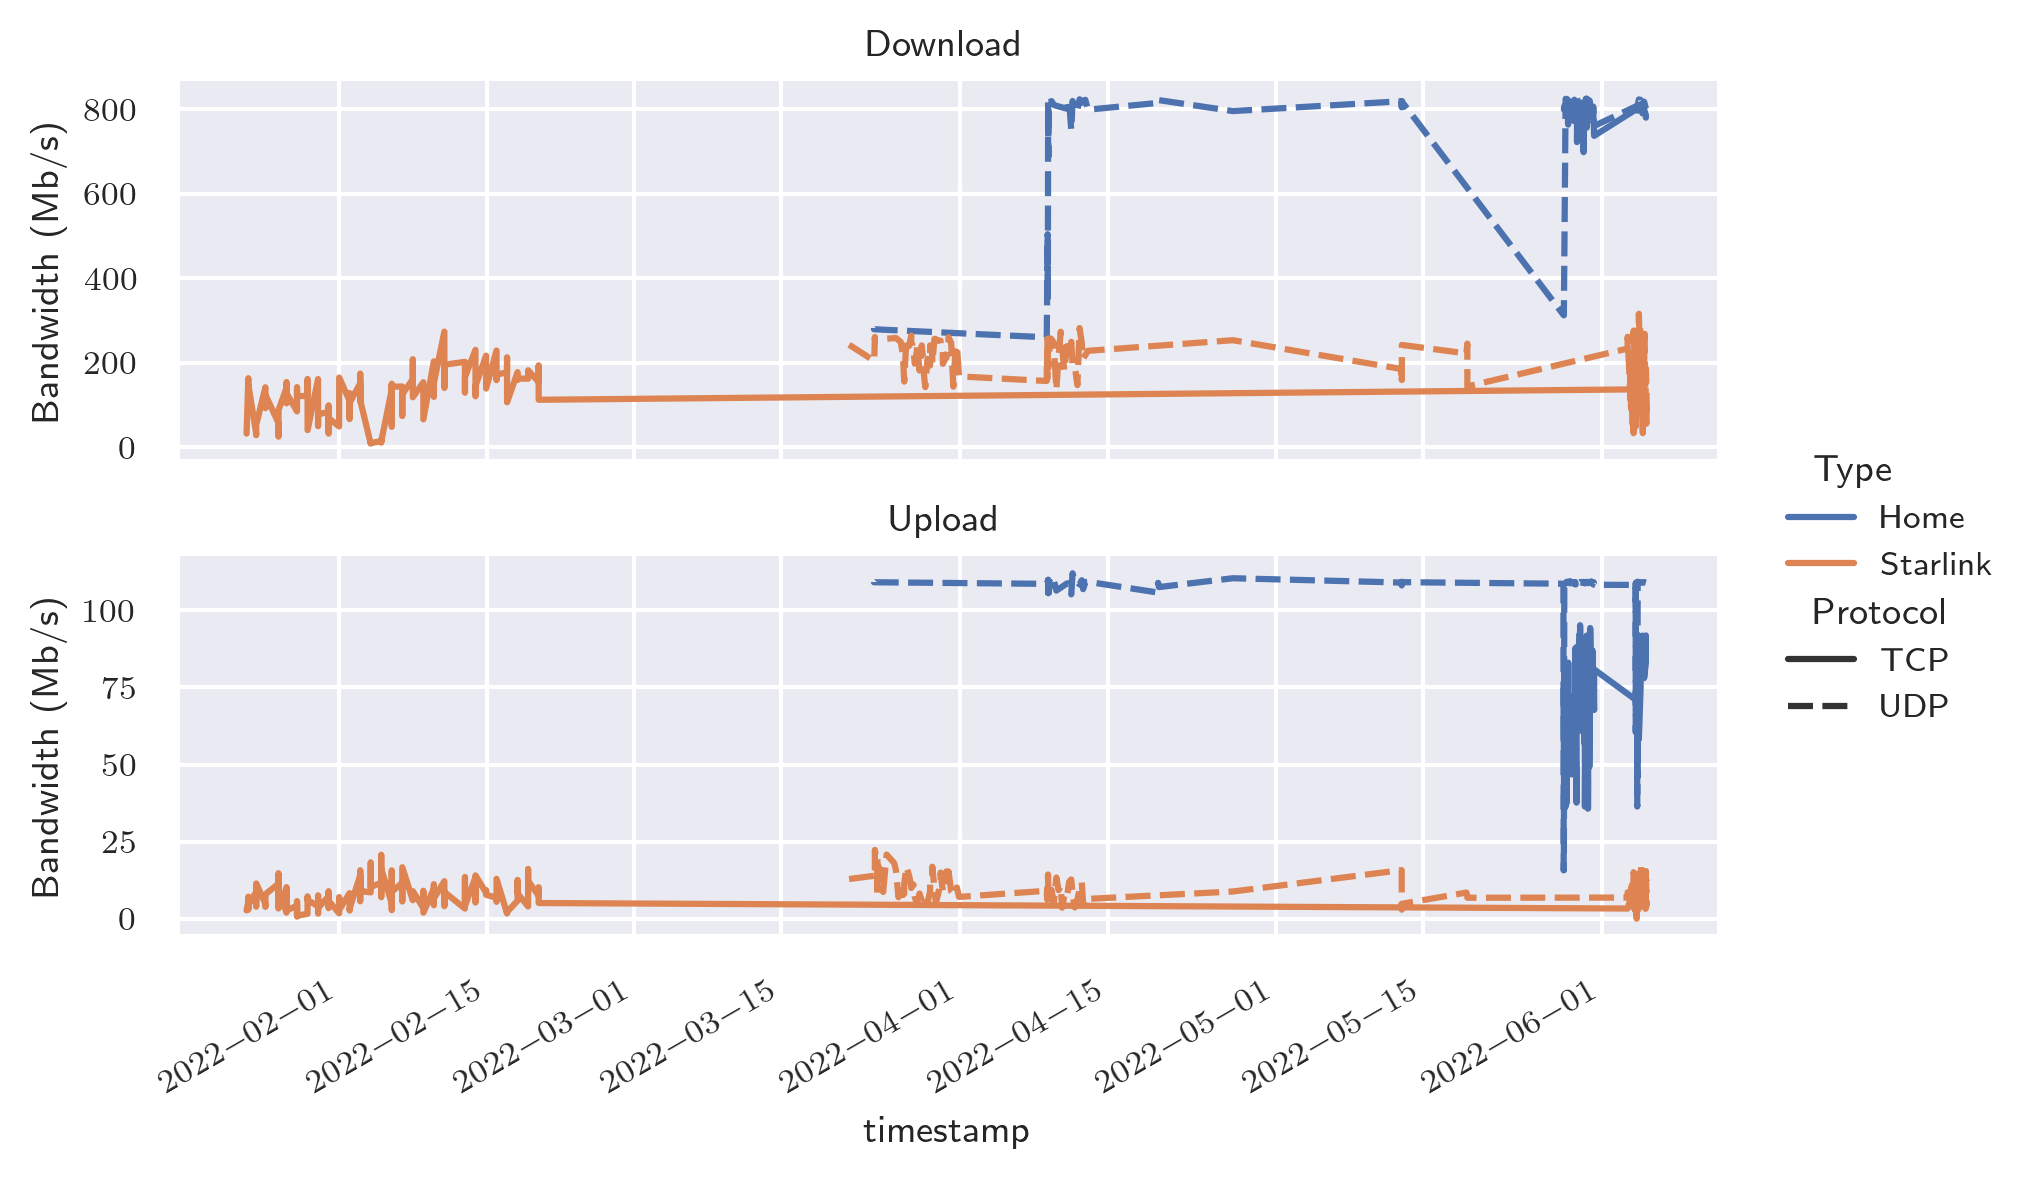

In [58]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#ax.xaxis.update_units(df.index)
#y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

temp = df_regs_interp
temp = temp.fillna(np.inf)
#temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_REGIONS] == 'N. California']
#g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_REGIONS,
#                style=COL_PROT_TYPE, style_order=PROT_TYPE_ORDER,
#                height=2, aspect=2.98,
#                kind='line',
#                x = 'timestamp', y='bandwidth',
#                facet_kws={'sharey': False})

g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_TYPE,
                style=N_PROTOCOL,
                height=2, aspect=2.98,
                kind='line',
                x = 'timestamp', y='bandwidth',
                facet_kws={'sharey': False})

#g_ax = g.fig.axes
#sns.scatterplot(data=df_outage, ax=g_ax)


#g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')

g.figure.autofmt_xdate()

#ax.set_ylabel("Jitter (ms)")
g.set_titles(row_template="{row_name}")
g.set(ylabel="Bandwidth (Mb/s)")
#g.set(yscale="log")
g.tight_layout()
#fig.tight_layout()

In [136]:
df_star = df_regs[df_regs[N_TYPE] == N_STARLINK]
df_star[df_star[N_PROTOCOL] == N_TCP].sort_values('timestamp')
#df_regs_interp.sort_values('timestamp')

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,Regions,Protocol,Transfer Direction,Type,Protocol and Type
97058,2022-01-23 04:35:16.000116224,8.918949,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
131372,2022-01-23 04:35:16.000148992,15.578690,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
98171,2022-01-23 04:35:17.000197888,9.353438,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
141419,2022-01-23 04:35:17.000263936,19.361028,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
146501,2022-01-23 04:35:18.000048896,23.225289,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...
11793,2022-06-05 05:14:27.000739072,0.000000,NaN,NaN,NaN,NaN,Cape Town,TCP,Upload,Starlink,TCP Starlink
222200,2022-06-05 05:14:28.000099840,92.677458,NaN,NaN,NaN,NaN,Cape Town,TCP,Download,Starlink,TCP Starlink
18791,2022-06-05 05:14:28.001073152,1.564906,NaN,NaN,NaN,NaN,Cape Town,TCP,Upload,Starlink,TCP Starlink
213915,2022-06-05 05:14:29.000040960,85.148361,NaN,NaN,NaN,NaN,Cape Town,TCP,Download,Starlink,TCP Starlink


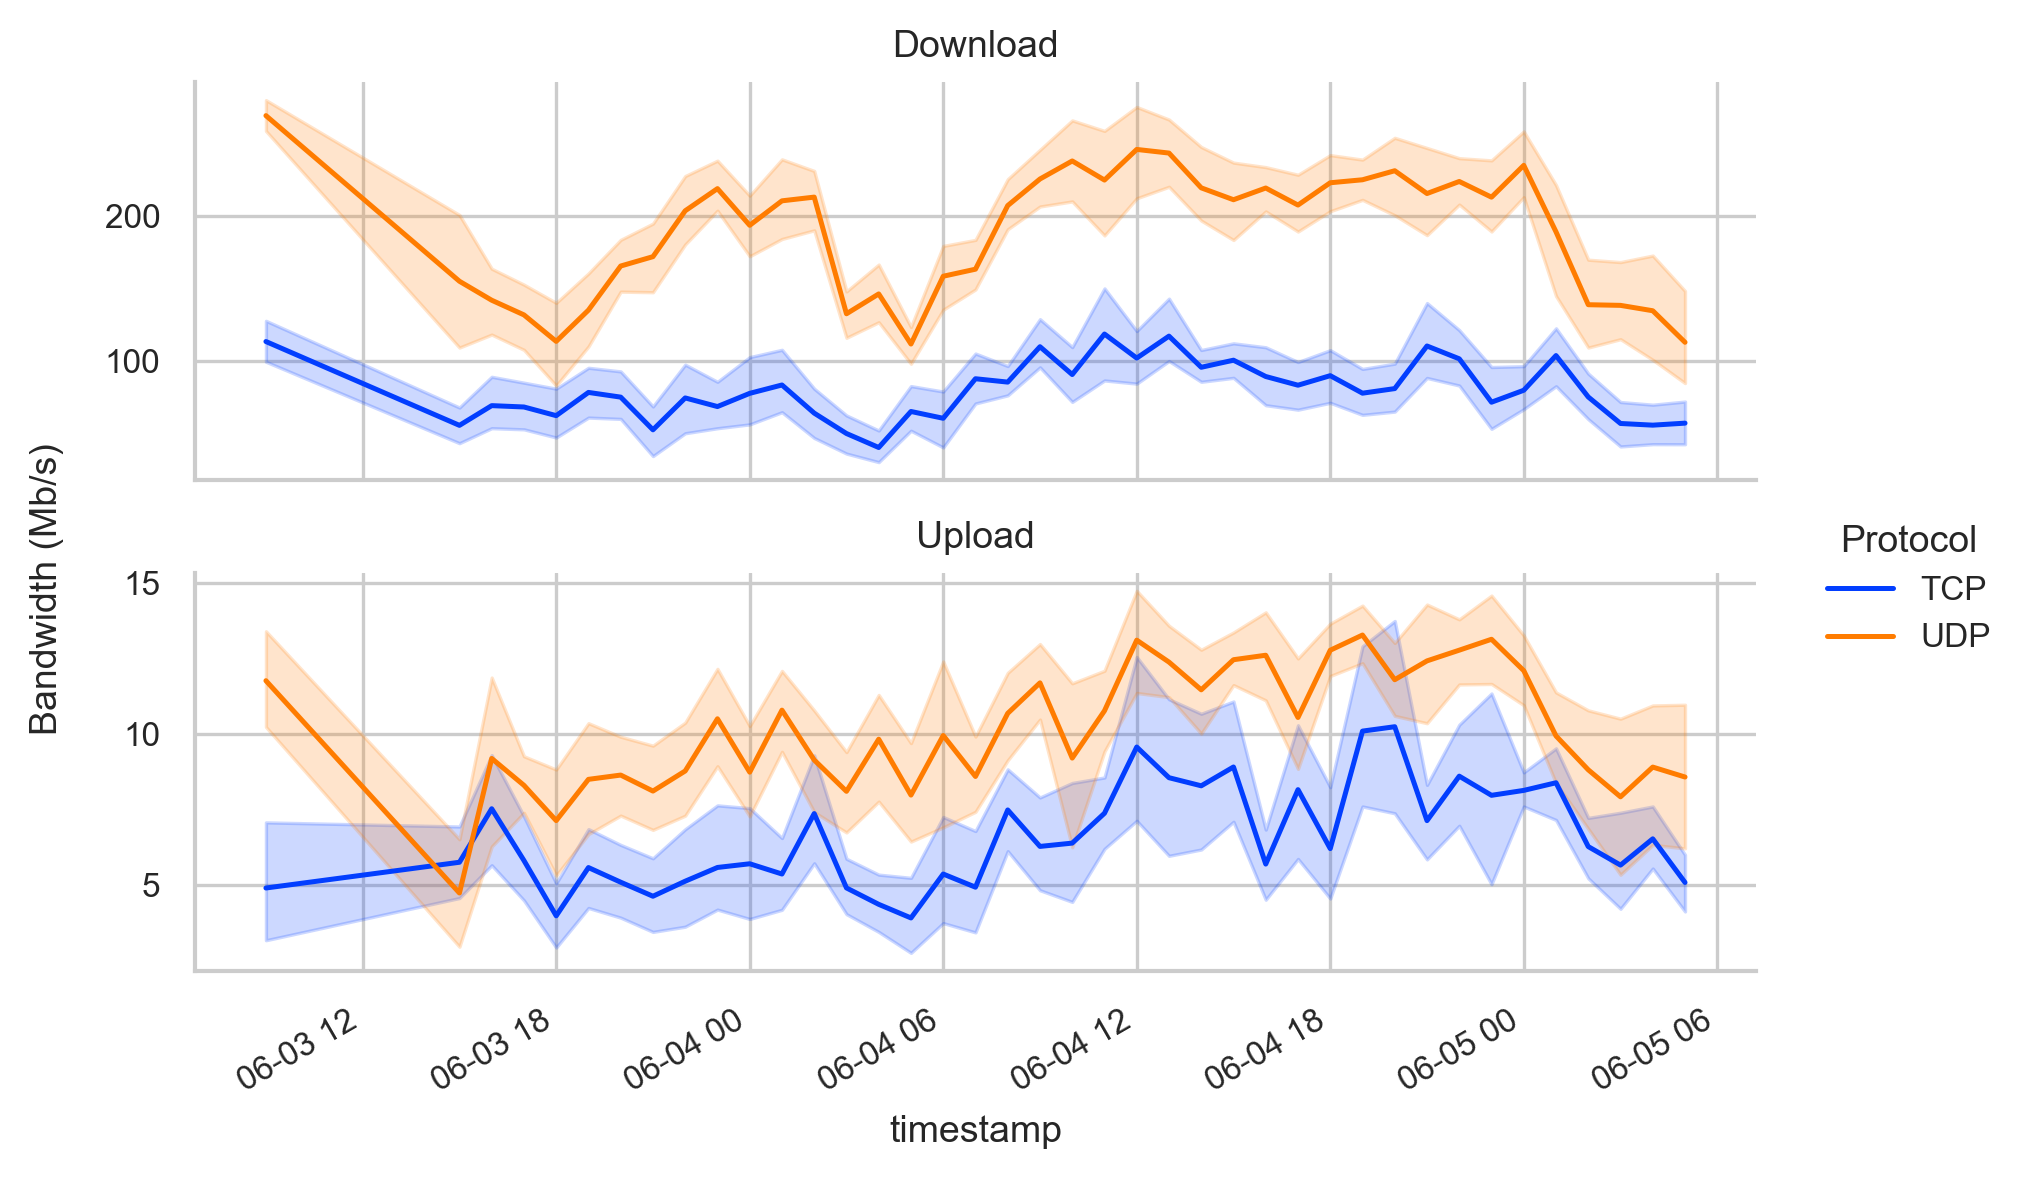

In [34]:
temp = df_regs_interp.copy()
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
#temp = temp[temp[N_PROTOCOL] == N_TCP]
temp['Day'] = temp.timestamp.dt.day

g_pat = sns.relplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=3.045,
                    kind='line',
                    x='timestamp', y='bandwidth',
                    facet_kws={'sharey': False})

g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Bandwidth (Mb/s)')
g_pat.tight_layout()

Day                          2          3          4          5          6
Transfer Direction                                                        
Download            107.592761   5.135047   6.388245  94.702639  90.205302
Upload                8.586459  11.634567  12.610558   8.401463   6.594147


Text(0.02, 0.5, 'Throughput (Mb/s)')

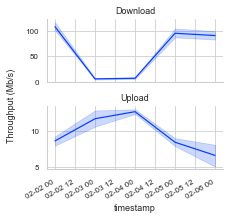

In [24]:
temp = df_regs_interp.copy()
temp = temp[(temp['timestamp'] >= '2022-02-02') & (temp['timestamp'] <= '2022-02-06')]
temp = temp[temp[N_TYPE] == N_STARLINK]
temp = temp[temp[N_PROTOCOL] == N_TCP]
#temp = temp[temp[COL_TRANSF_DIR] == N_DOWN]
temp['Day'] = temp.timestamp.dt.day
print(temp.pivot_table(index=COL_TRANSF_DIR, columns='Day', values='bandwidth'))

g_single = sns.relplot(data=temp, 
                    row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                    #hue=N_REGIONS, hue_order=common.REGION_ORDER,
                    # style=N_PROTOCOL,
                    height=1.5, aspect=2.2,
                    kind='line',
                    x='timestamp', y='bandwidth',
                    facet_kws={'sharey': False})

g_single.figure.autofmt_xdate()

g_single.set_titles(row_template="{row_name}")
g_single.set(ylabel="")
g_single.figure.supylabel('Throughput (Mb/s)')


In [25]:
g_single.savefig(f'{OUTPUT_FOLDER}/2022-02-02_starlink_throughput_outage.pdf', bbox_inches='tight')

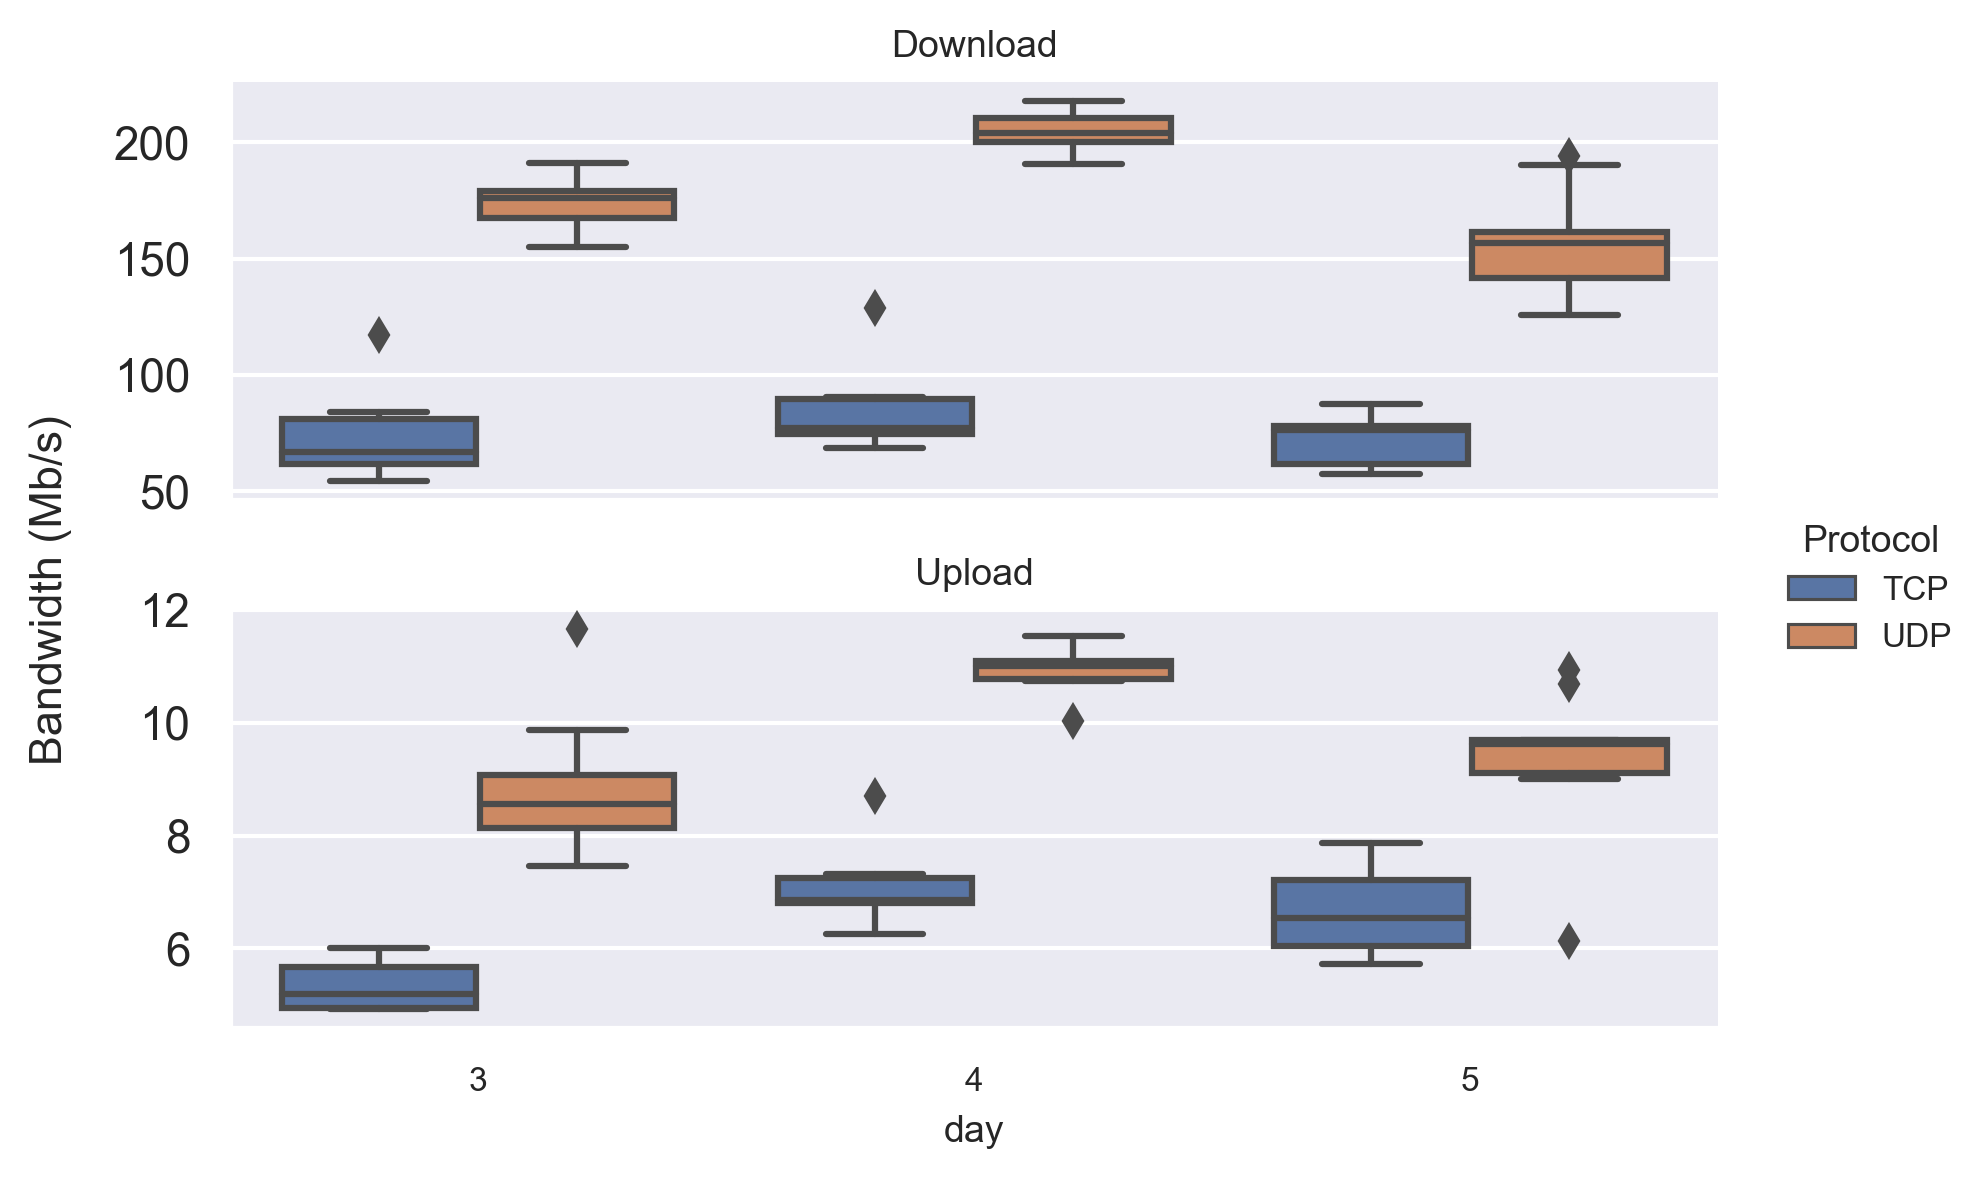

In [80]:
temp = df_regs_interp
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
temp['day'] = temp.timestamp.dt.day

g_pat = sns.catplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=2.98,
                    kind='box', sharey=False,
                    x='day', y='bandwidth')

#g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Bandwidth (Mb/s)')
g_pat.tight_layout()

In [ ]:
from matplotlib.patches import Rectangle
g_bar = sns.catplot(data=df_regs,
                    col=N_PROTOCOL,
                    x=N_REGIONS, y='bandwidth',hue=N_TYPE,
                    ci='sd', 
                    kind='bar', legend=False,
                    height=2, aspect=1.79, col_wrap=2)

#g_bar.set_xticklabels(['TD', 'TU', 'UD', 'UU'])
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
g_bar.figure.autofmt_xdate()
g_bar.set_titles(col_template="{col_name}")
g_bar.axes.flatten()[1].legend()
#g_bar.add_legend(loc='upper right')
#g_bar.figure.legend([extra, extra, extra, extra], 
#                    ('TD = TCP Download','TU = TCP Upload', 
#                     'UD = UDP Download', 'UU = UDP Upload'),
#                   frameon=False, loc='lower right')
g_bar.set(ylabel="Bandwidth (Mb/s)")
g_bar.tight_layout()

In [165]:
g_bar.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_summary.pgf'), bbox_inches='tight')

In [219]:
df_downs_only = df_regs[df_regs[N_PROTOCOL].isin([TCP_DOWN, UDP_DOWN])]
df_downs_only[df_downs_only[[N_PROTOCOL, N_REGIONS]].agg('-'.join, axis=1)

0                TCP Down-Mumbai
1                TCP Down-Sydney
2                TCP Down-Sydney
3                TCP Down-Sydney
4                TCP Down-Sydney
                   ...          
112355    UDP Down-N. California
112356    UDP Down-N. California
112357    UDP Down-N. California
112358    UDP Down-N. California
112359    UDP Down-N. California
Length: 73091, dtype: object

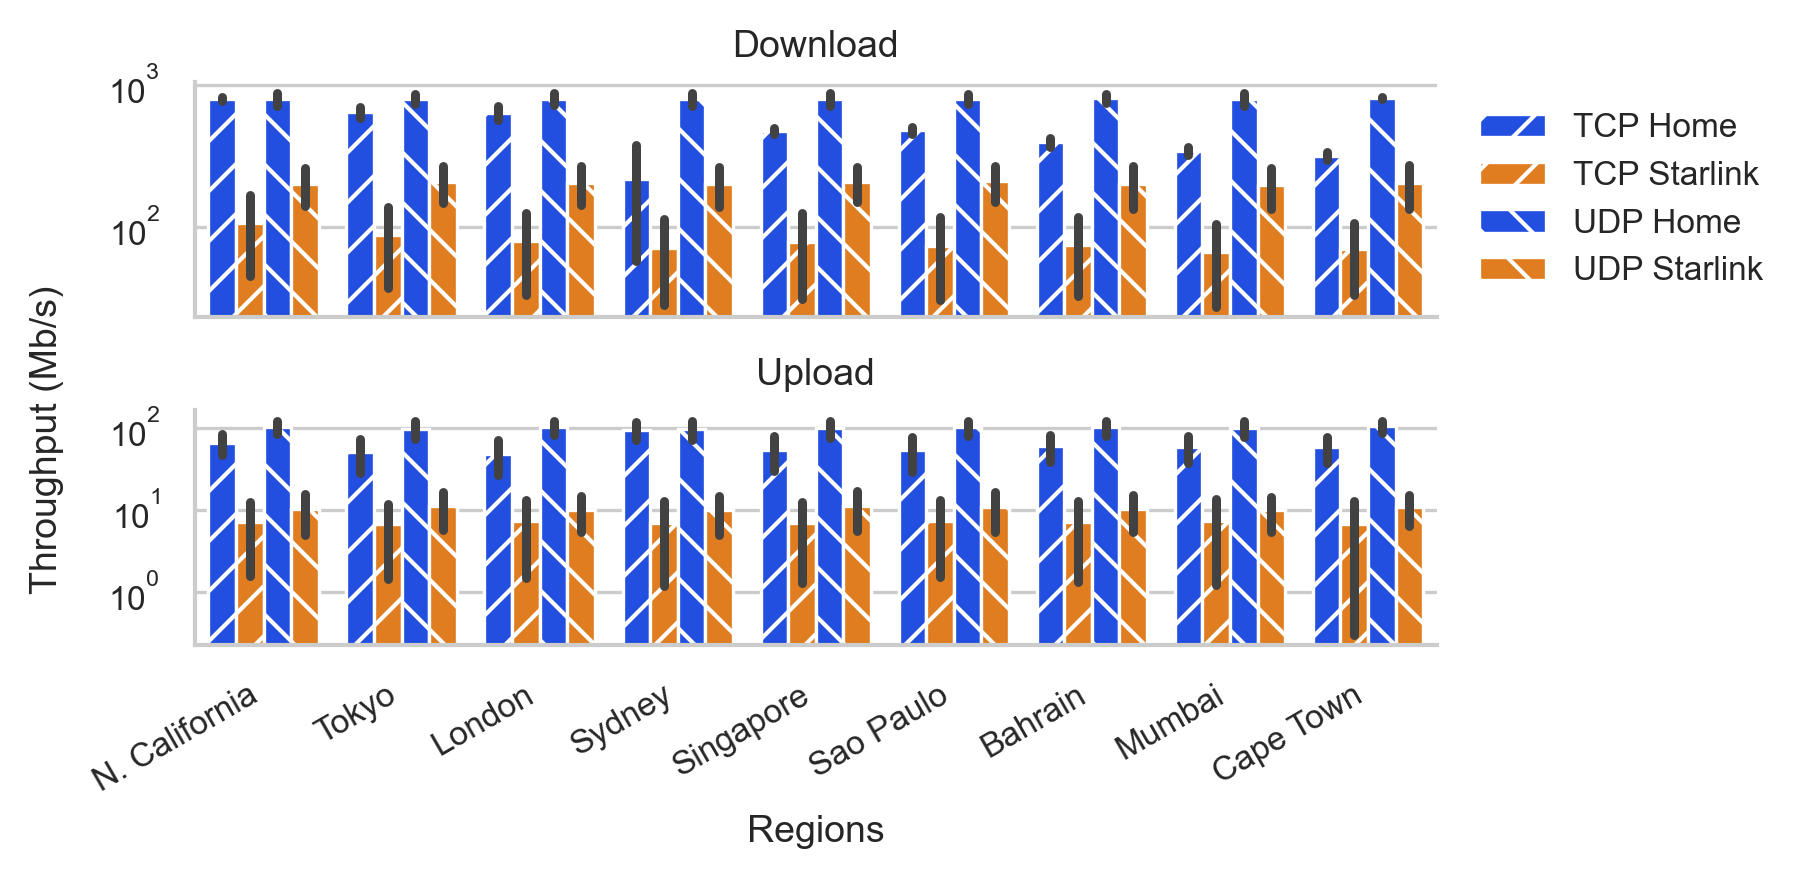

In [75]:
#temp = df_regs.loc['2022-06-03':]
#sns.set_palette('bright')
g_avg = sns.catplot(data=df_regs_old,
                    row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS, y='bandwidth', hue=COL_PROT_TYPE,
                    hue_order=PROT_TYPE_ORDER, row_order=[N_DOWN, N_UP],
                    order=common.REGION_ORDER,
                    legend=False,
                    palette=['C0', 'C1', 'C0', 'C1'],
                    kind='bar', ci='sd',
                    height=1.5, aspect=4.06)

num_locs = len(df_regs[N_REGIONS].unique())
hatches = itertools.cycle(['//','//', '\\\\', '\\\\'])
axes = g_avg.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="{row_name}")
g_avg.set(ylabel="")
g_avg.figure.supylabel("Throughput (Mb/s)", fontsize=9)
g_avg.tight_layout()

In [76]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_throughput.pdf'), bbox_inches='tight')

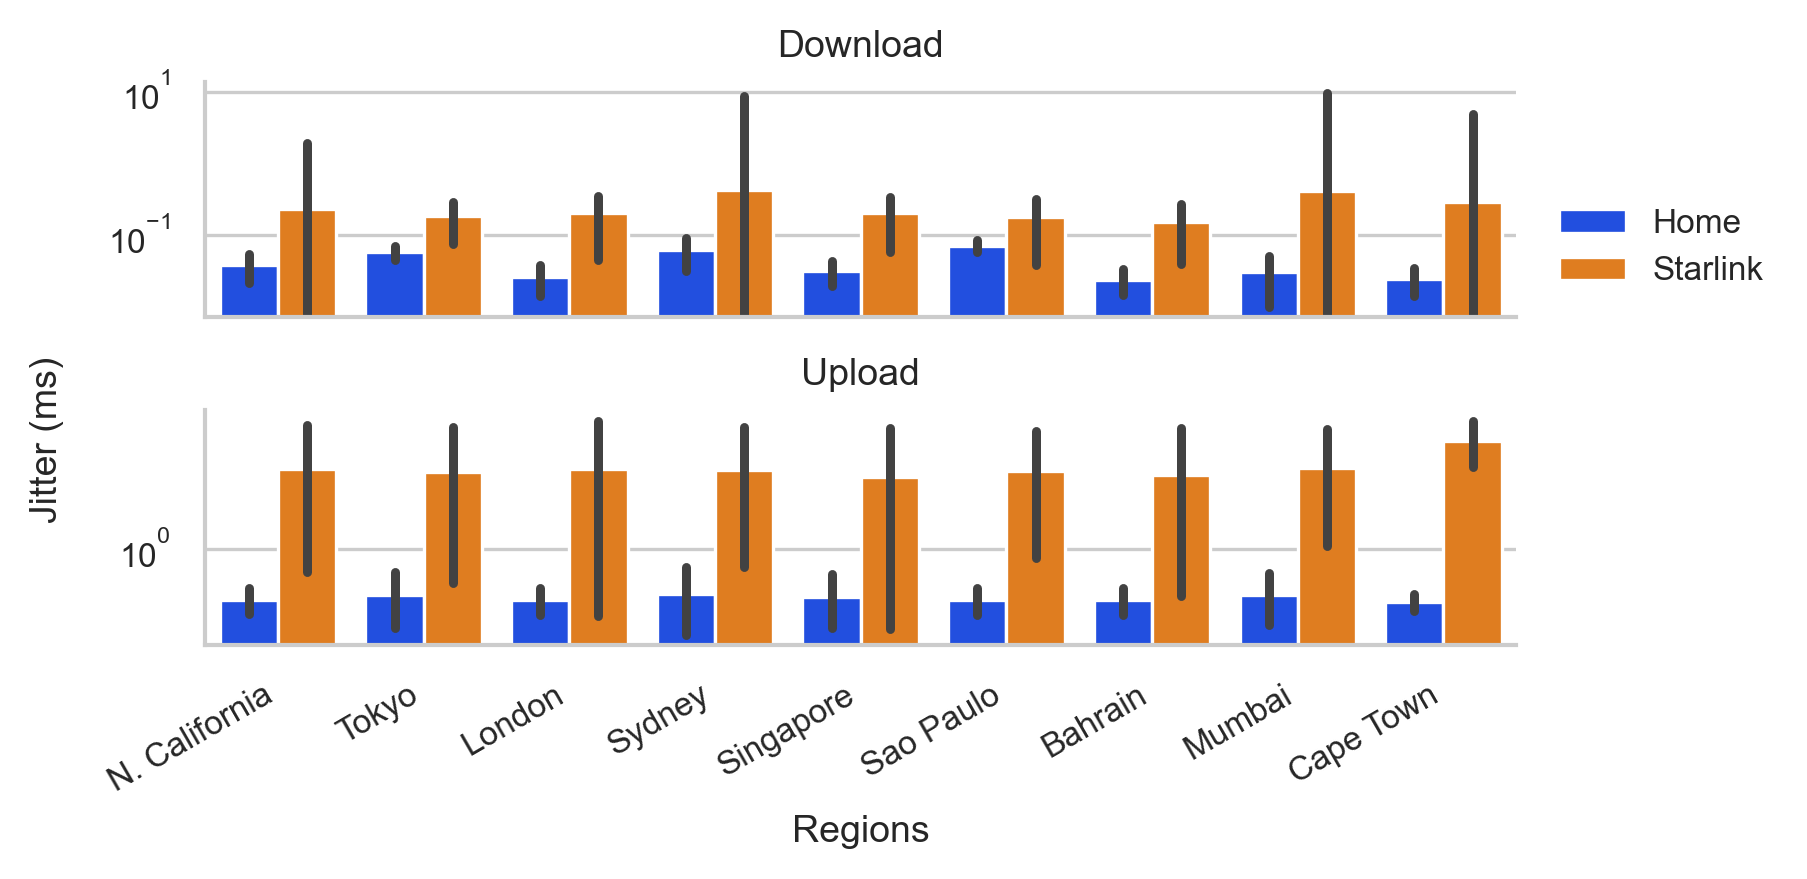

In [27]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('bright')
tmp = df_outliers[(df_outliers[N_TYPE] == N_STARLINK) | (df_outliers[N_THROUGHPUT_OUTLIERS] == False)]
g_jitter = sns.catplot(data=tmp,
                    row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS,
                    row_order=[N_DOWN, N_UP],
                    y='jitter_ms', 
                    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
                    order=common.REGION_ORDER,
                    legend=False,
                    kind='bar', ci='sd',
                    height=1.5, aspect=4.06)

#num_locs = len(df_regs[N_REGIONS].unique())
#hatches = itertools.cycle(['//', '\\\\'])
axes = g_jitter.axes.flatten()
#for ax in axes:
#    for i, bar in enumerate(ax.patches):
#        if i % num_locs == 0:
#            hatch = next(hatches)
#        bar.set_hatch(hatch)
#        #print(bar.get_facecolor())
#        #bar.set_color(colour)

axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
g_jitter.figure.autofmt_xdate()
g_jitter.set_titles(row_template="{row_name}")
g_jitter.set(ylabel="")
g_jitter.figure.supylabel("Jitter (ms)", fontsize=9)
g_jitter.tight_layout()

In [28]:
g_jitter.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_udp_jitter_avg.pdf'), bbox_inches='tight')

In [29]:
tmp.pivot_table(index=COL_TRANSF_DIR, columns=N_TYPE, values='jitter_ms')

Type,Home,Starlink,Starlink Remote
Transfer Direction,,,
Download,0.041103,0.254756,0.925259
Upload,0.545534,2.715160,8.988243


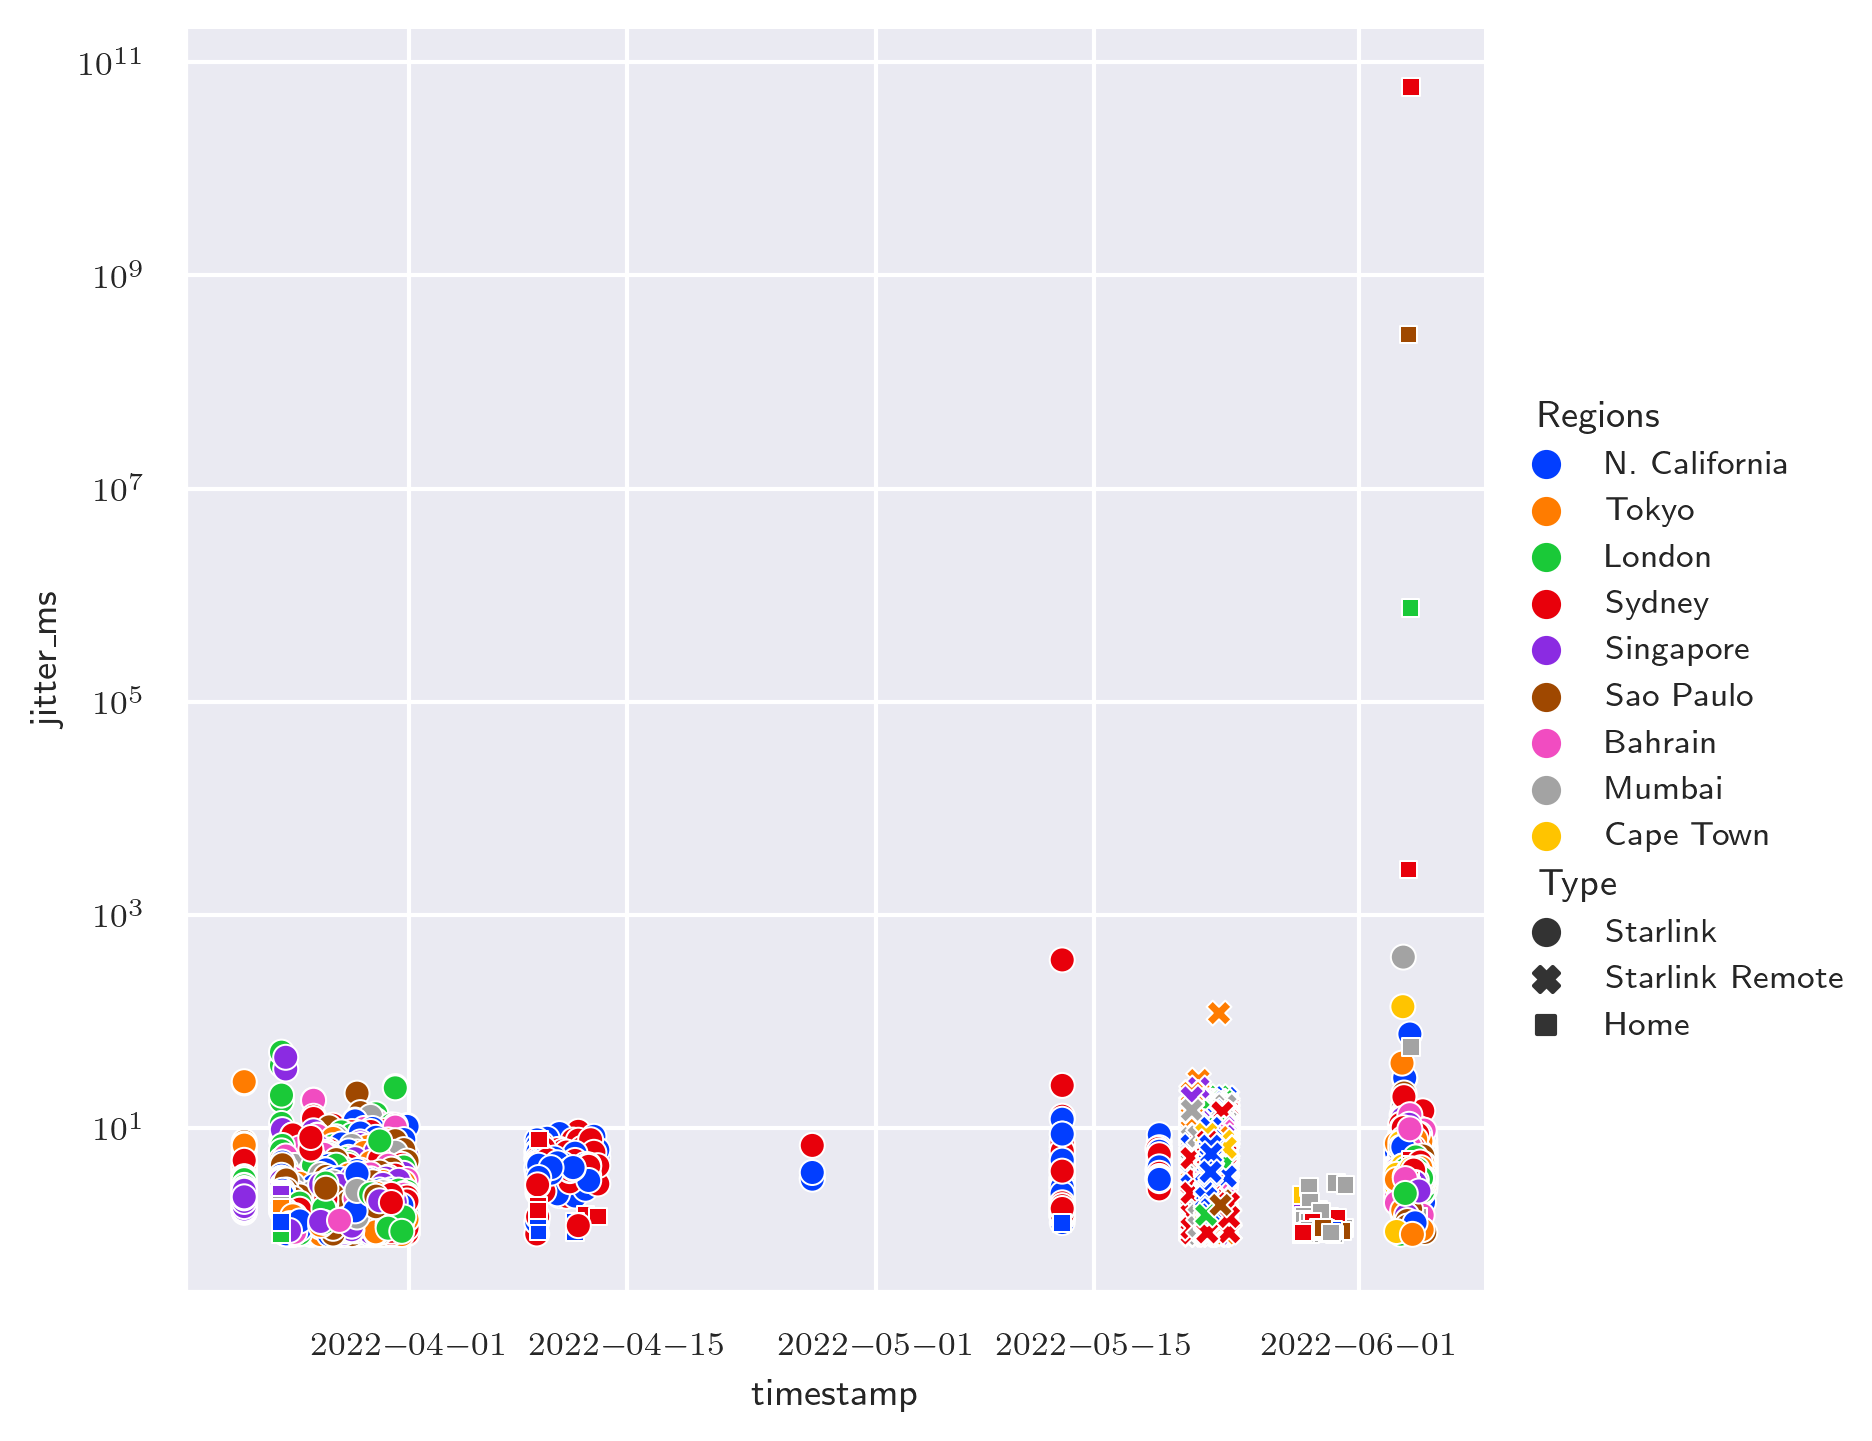

In [136]:
df_home_jitter_out = df_outliers[(df_outliers['jitter_ms'] > 1)]
g_out = sns.relplot(
    data=df_home_jitter_out,
    x='timestamp',
    y='jitter_ms',
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    style=N_TYPE,
)

g_out.set(yscale='log')

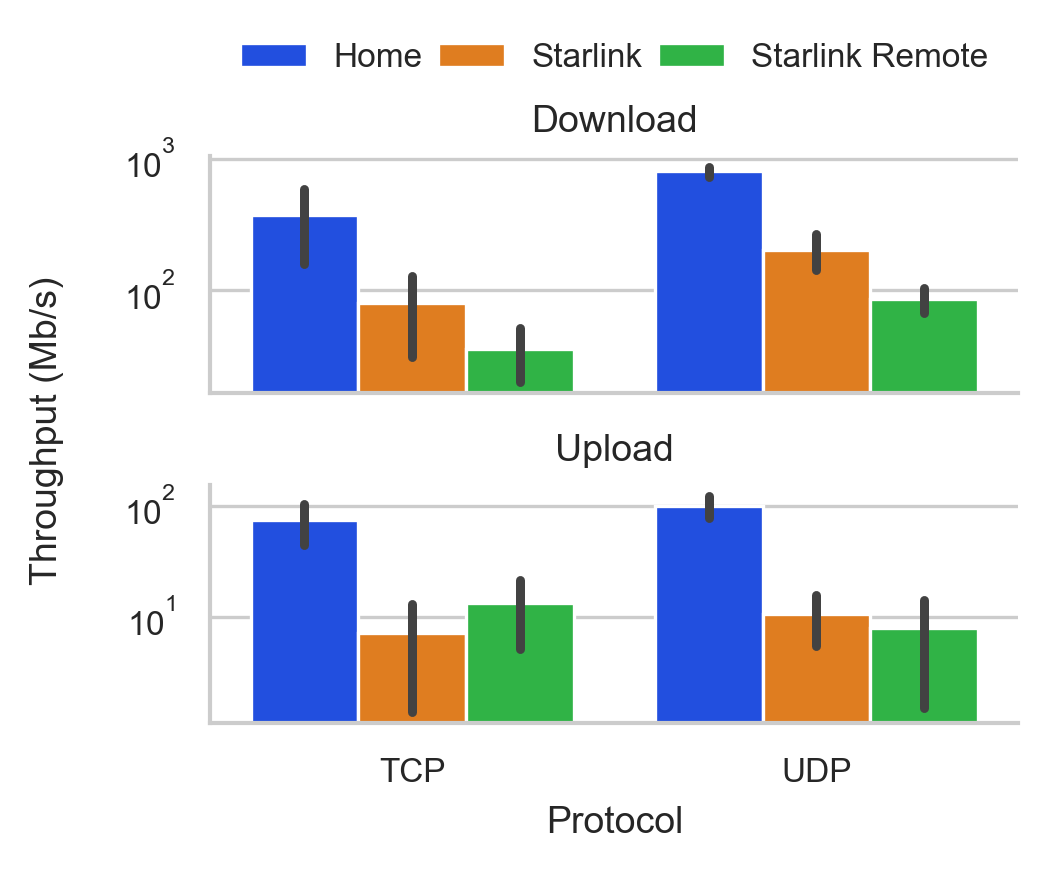

In [81]:
#temp = df_regs.loc['2022-06-03':]
g_avg_small = sns.catplot(data=df_regs_all, row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_PROTOCOL, y='bandwidth', hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK, N_STARLINK_REMOTE],
                    #palette=['C3']*3,
                    order=[N_TCP, N_UDP], row_order=[N_DOWN, N_UP],
                    legend=False,
                    kind='bar', ci='sd',
                    height=1.5, aspect=2.3333)

axes = g_avg_small.axes.flatten()

#axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.22,1,0.2), ncol=3, mode='expand', fancybox=True, frameon=False)
#axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode='expand', ncol=3, fancybox=True, frameon=False)
#g_avg_small.figure.autofmt_xdate()
g_avg_small.set_titles(row_template="{row_name}")
g_avg_small.set(ylabel="")
g_avg_small.figure.supylabel("Throughput (Mb/s)", fontsize=9)
g_avg_small.tight_layout()

In [82]:
g_avg_small.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-21_end_throughput_koeye_summary.pdf'), bbox_inches='tight')

In [13]:
sns.plotting_context()

{'font.size': 9.0,
 'axes.labelsize': 9.0,
 'axes.titlesize': 9.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.8,
 'legend.fontsize': 8.0,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'legend.title_fontsize': 9.0}

In [29]:
def diff_table(table):
    df_perc = table.pivot_table(index=[N_PROTOCOL, N_REGIONS], columns=N_TYPE, values='bandwidth')
    df_perc['diff'] = df_perc['Home'] - df_perc['Starlink']
    return df_perc.reset_index().pivot_table(index=N_PROTOCOL, columns=N_REGIONS, values='diff')

#diff_table(df_regs)
#diff_table(df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).mean().reset_index())

#df_agg = df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).max().reset_index()

#df_agg.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL], values='bandwidth')
#df_agg = df_regs[df_regs[N_TYPE] == N_STARLINK]
#df_agg = df_agg[df_agg[COL_TRANSF_DIR] == N_DOWN]
#df_agg = df_agg[df_agg[N_PROTOCOL] == N_UDP]
#df_agg = df_agg[df_agg['lost_percent'] == 0]
#df_agg[df_agg['bandwidth'] < 200]

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Protocol,,,,,,,,,
TCP,185.522191,149.177327,299.328687,163.080643,371.702437,225.167185,220.874687,117.946149,299.002705
UDP,302.338865,321.911059,299.337305,295.839713,308.140715,304.474719,281.216713,260.982379,278.296849


In [40]:
#df_avg = df_outliers[df_outliers['bandwidth'] > 0]
#df_avg = df_avg[df_avg[N_THROUGHPUT_OUTLIERS] == False]
#df_avg = df_regs.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values='bandwidth', aggfunc='count').reindex(common.REGION_ORDER)

df_avg = df_outliers[df_outliers[N_THROUGHPUT_OUTLIERS] == False]
df_avg = df_avg.pivot_table(
    index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth',
    aggfunc=np.max
)
#styler = df_avg.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_avg
#df_scale = pd.DataFrame()
#left_comp = N_STARLINK
#right_comp = N_HOME
#df_scale[N_TCP] = df_avg[left_comp][N_TCP] / df_avg[right_comp][N_TCP]
#df_scale[N_UDP] = df_avg[left_comp][N_UDP] / df_avg[right_comp][N_UDP]
#df_scale['R_TCP / R_UDP'] = df_avg[N_STARLINK_REMOTE][N_UDP] / df_avg[N_STARLINK_REMOTE][N_TCP]
#df_scale

Type                      Home                Starlink              \
Protocol                   TCP         UDP         TCP         UDP   
Transfer Direction                                                   
Download            844.888201  838.443014  293.006045  327.414891   
Upload              123.221869  118.482285   26.079626   27.880175   

Type               Starlink Remote              
Protocol                       TCP         UDP  
Transfer Direction                              
Download                 90.539529  123.032775  
Upload                   39.097370   30.432014

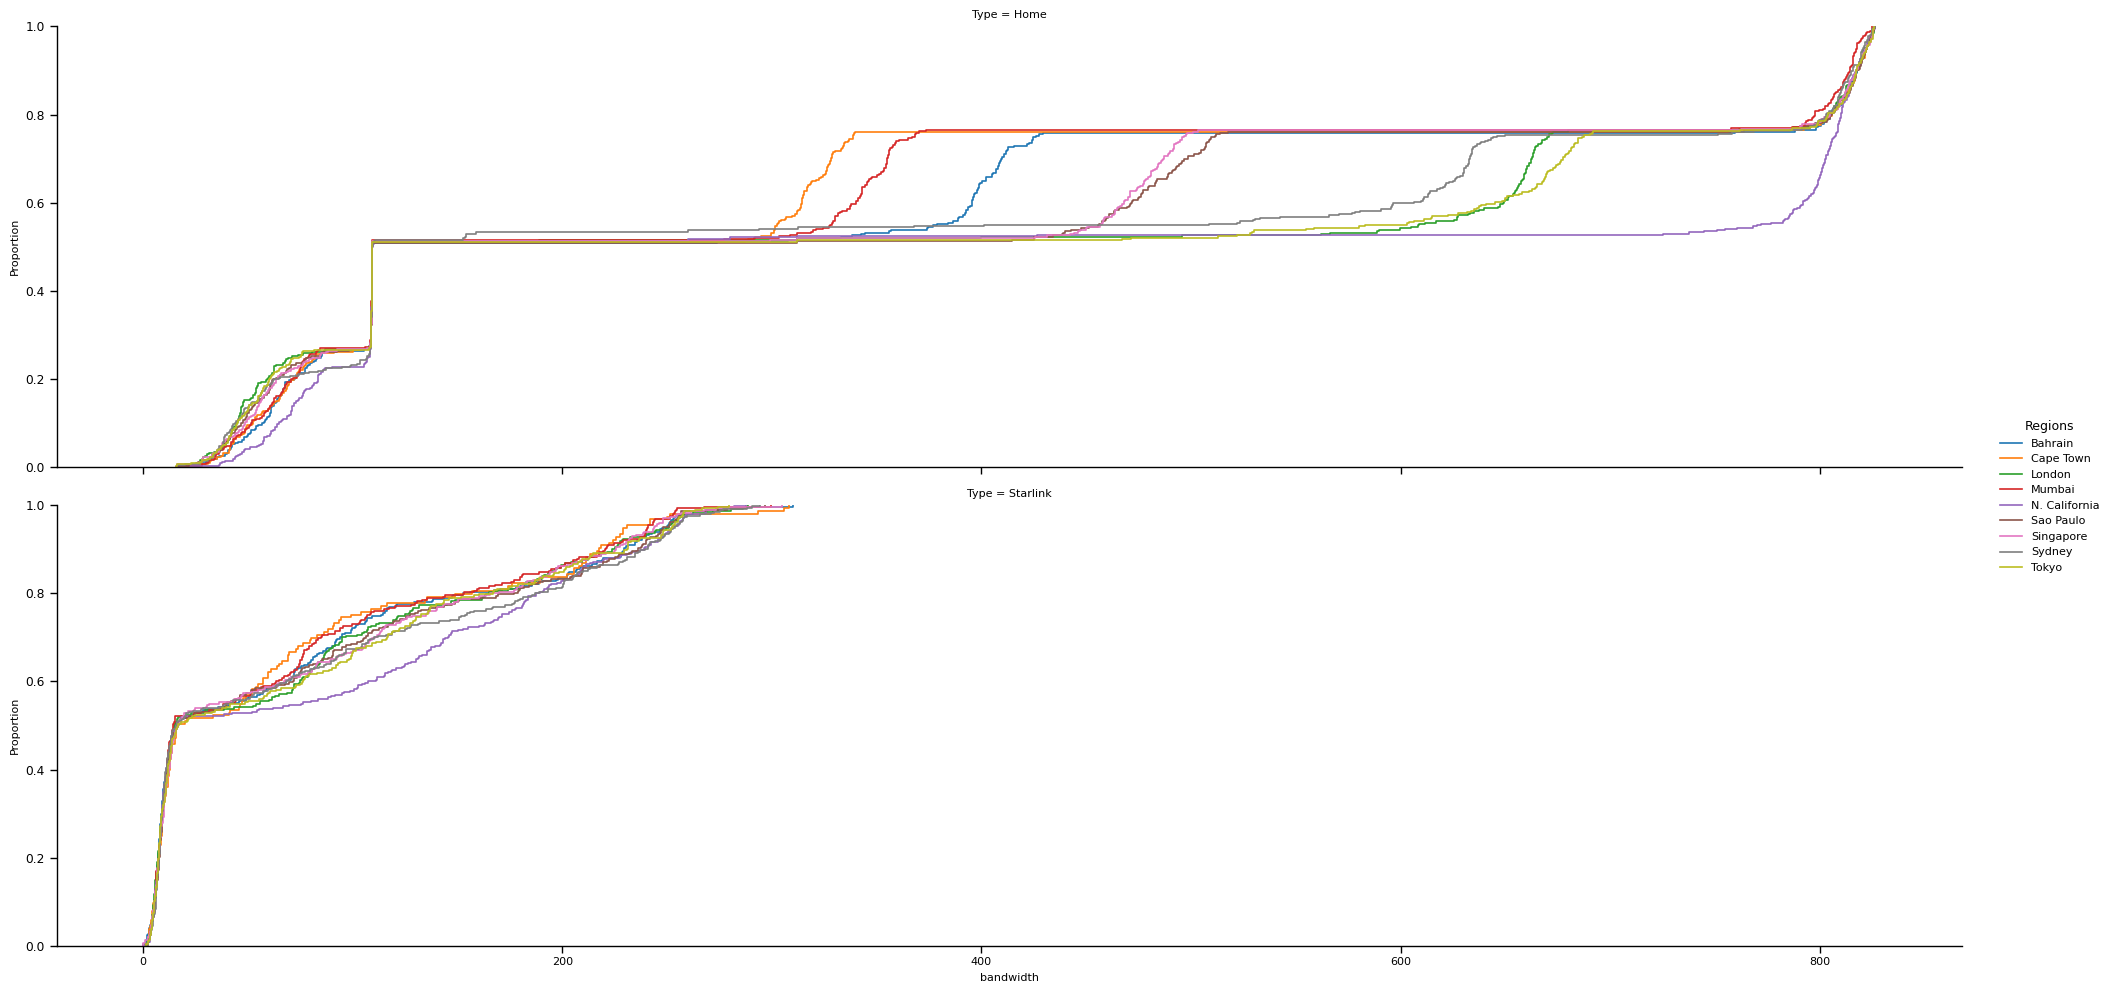

In [135]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, height=5, aspect=4)
g2.map(sns.ecdfplot, 'bandwidth')
g2.add_legend()
g2.tight_layout()
#fig2.tight_layout()

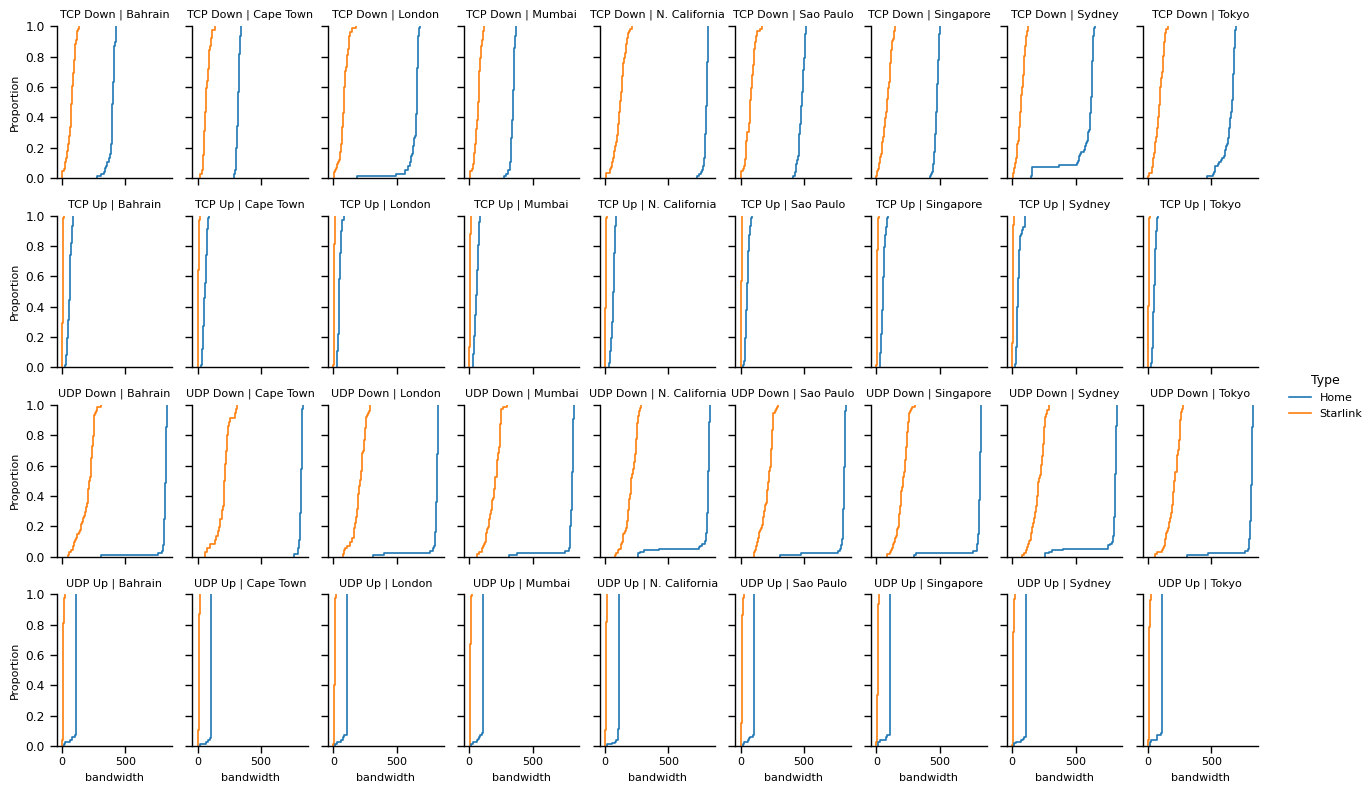

In [136]:
g_hist = sns.displot(
    data=df_unstacked, 
    x='bandwidth', col=N_REGIONS, row=N_PROTOCOL, hue=N_TYPE, kind='ecdf', height=2, aspect=0.716)
g_hist.set_titles(col_template="{col_name}", row_template="{row_name}")
g_hist.tight_layout()

In [150]:
g.savefig(f'output/throughput/throughput.pdf', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')